# Inpainting missing data

Missing data in an image can be an issue, especially when one wants to perform Fourier analysis.
This tutorial explains how to fill-up missing pixels with values which looks "realistic" and introduce as little perturbation as possible for subsequent analysis.
The user should keep the mask nearby and only consider the values of actual pixels and never the one inpainted.

This tutorial will use fully synthetic data to allow comparison between actual (syntetic) data with inpainted values.

The first part of the tutorial is about the generation of a challenging 2D diffraction image with realistic noise and to describe the metric used, then comes the actual tutorial on how to use the inpainting. Finally a benchmark is used based on the metric determined.

## Creation of the image

A realistic challenging image should contain:

* Bragg peak rings. We chose LaB6 as guinea-pig, with very sharp peaks, at the limit of the resolution of the detector
* Some amorphous content
* strong polarization effect
* Poissonian noise


One image will be generated but then multiple ones with different noise to discriminate the effect of the noise from other effects.

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyFAI
print("Using pyFAI version: ", pyFAI.version)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
import pyFAI.test.utilstest
from pyFAI.calibrant import get_calibrant
import time
start_time = time.time()

Using pyFAI version:  0.18.0


In [3]:
detector = pyFAI.detector_factory("Pilatus2MCdTe")
mask = detector.mask.copy()
nomask = numpy.zeros_like(mask)
detector.mask=nomask
ai = AzimuthalIntegrator(detector=detector)
ai.setFit2D(200, 200, 200)
ai.wavelength = 3e-11
print(ai)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 3.000000e-11m
SampleDetDist= 2.000000e-01m	PONI= 3.440000e-02, 3.440000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 200.000mm	Center: x=200.000, y=200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


LaB6 Calibrant with 640 reflections at wavelength 3e-11


<IPython.core.display.Javascript object>


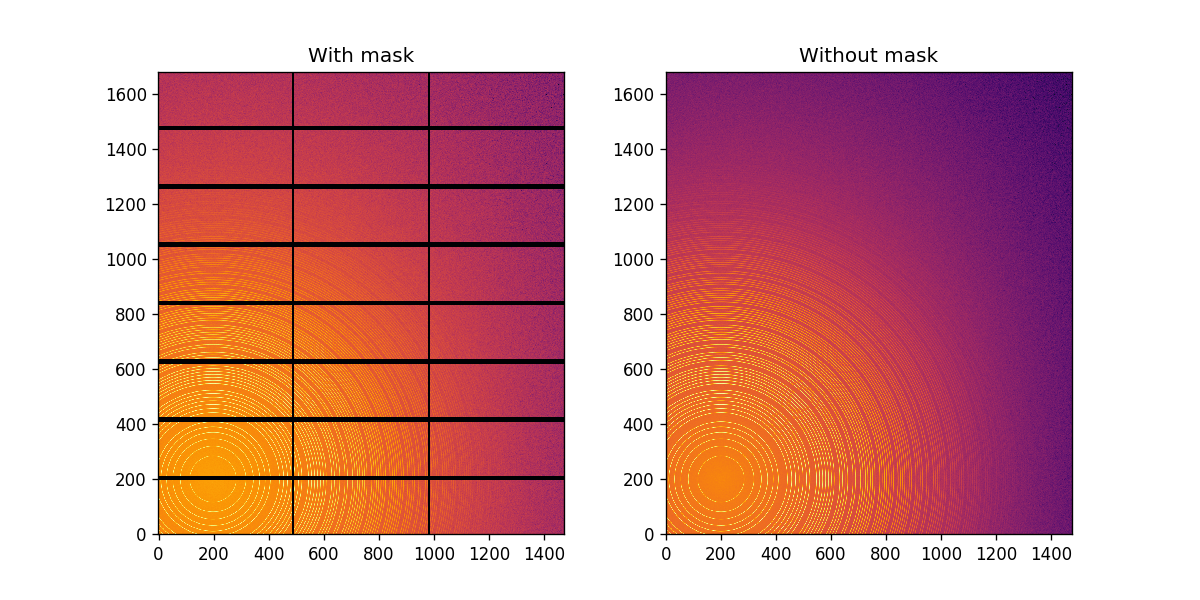

In [4]:
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = ai.wavelength
print(LaB6)
r = ai.array_from_unit(unit="q_nm^-1")
decay_b = numpy.exp(-(r-50)**2/2000)
bragg = LaB6.fake_calibration_image(ai, Imax=1e4, W=1e-6) * ai.polarization(factor=1.0) * decay_b
decay_a = numpy.exp(-r/100)
amorphous = 1000*ai.polarization(factor=1.0)*ai.solidAngleArray() * decay_a
img_nomask = bragg + amorphous
#Not the same noise function for all images two images
img_nomask = numpy.random.poisson(img_nomask)
img_nomask2 = numpy.random.poisson(img_nomask)
img = numpy.random.poisson(img_nomask)
img[numpy.where(mask)] = -1
fig,ax = subplots(1,2, figsize=(10,5))
jupyter.display(img=img, label="With mask", ax=ax[0])
jupyter.display(img=img_nomask, label="Without mask", ax=ax[1])

Note the aliassing effect on the displayed images.

We will measure now the effect after 1D intergeration. We do not correct for polarization on purpose to highlight the defect one wishes to whipe out. We use a R-factor to describe the quality of the 1D-integrated signal. 

<IPython.core.display.Javascript object>


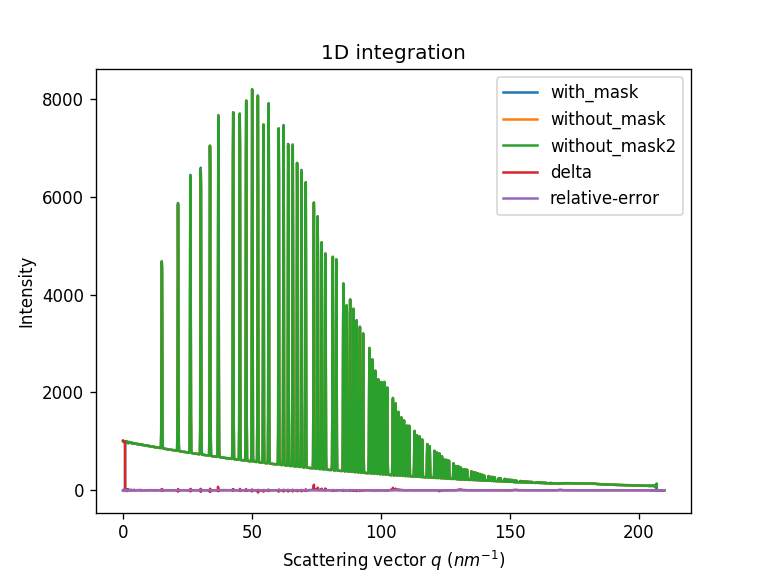

Between masked and non masked image R= 5.674716226129594
Between two different non-masked images R'= 0.20052620486377865


In [5]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo2 = ai.integrate1d(img_nomask2, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wm = ai.integrate1d(img, 2000, unit="q_nm^-1", method="splitpixel", mask=mask, radial_range=(0,210))
ax = jupyter.plot1d(wm , label="with_mask")
ax.plot(*wo, label="without_mask")
ax.plot(*wo2, label="without_mask2")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.plot(wo.radial, wo.intensity-wo2.intensity, label="relative-error")
ax.legend()
print("Between masked and non masked image R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))
print("Between two different non-masked images R'= %s"%pyFAI.utils.mathutil.rwp(wo2,wo))

<IPython.core.display.Javascript object>


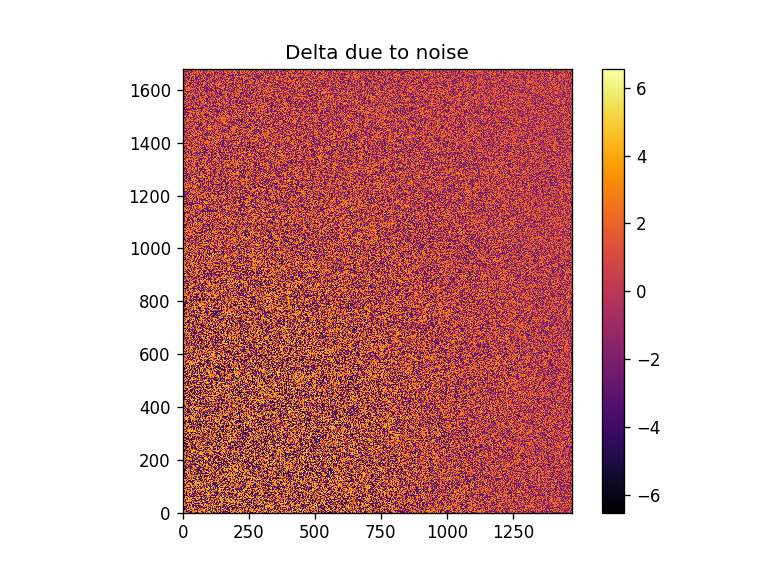

In [6]:
# Effect of the noise on the delta image
fig, ax = subplots()
jupyter.display(img=img_nomask-img_nomask2, label="Delta due to noise", ax=ax)
ax.figure.colorbar(ax.images[0])

## Inpainting

This part describes how to paint the missing pixels for having a "natural-looking image". The delta image contains the difference with the original image

<IPython.core.display.Javascript object>


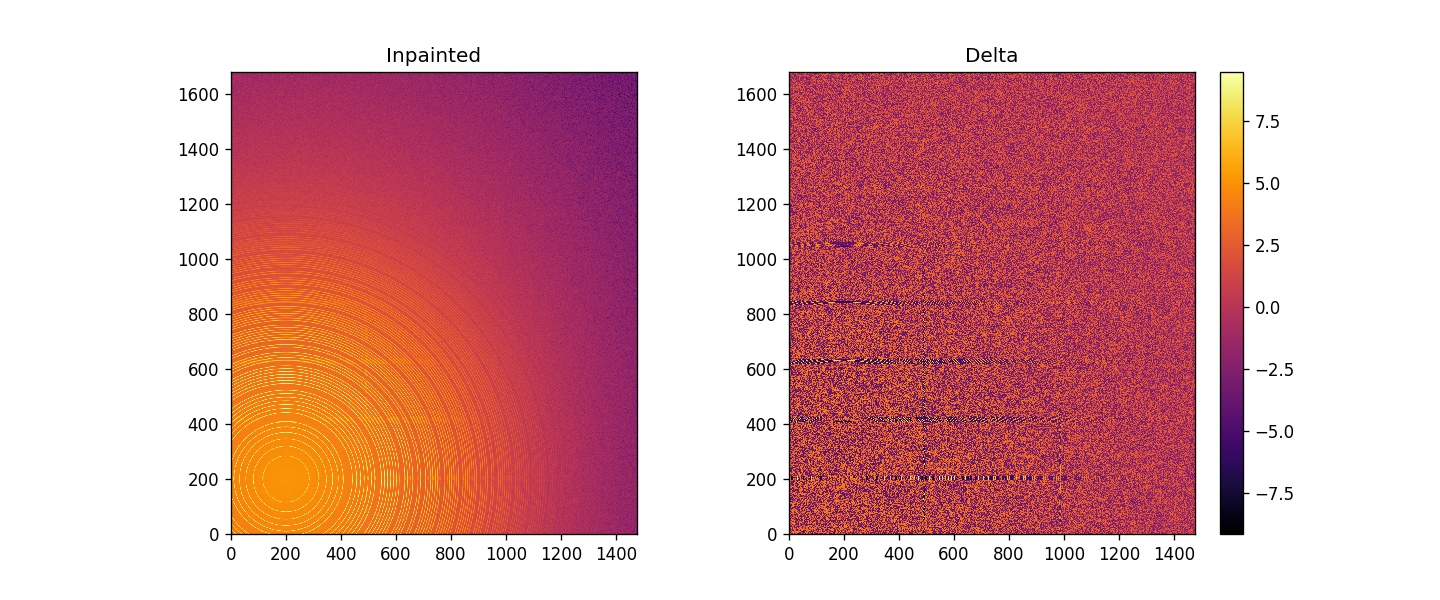

In [7]:
#Inpainting:
inpainted = ai.inpainting(img, mask=mask, poissonian=True)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


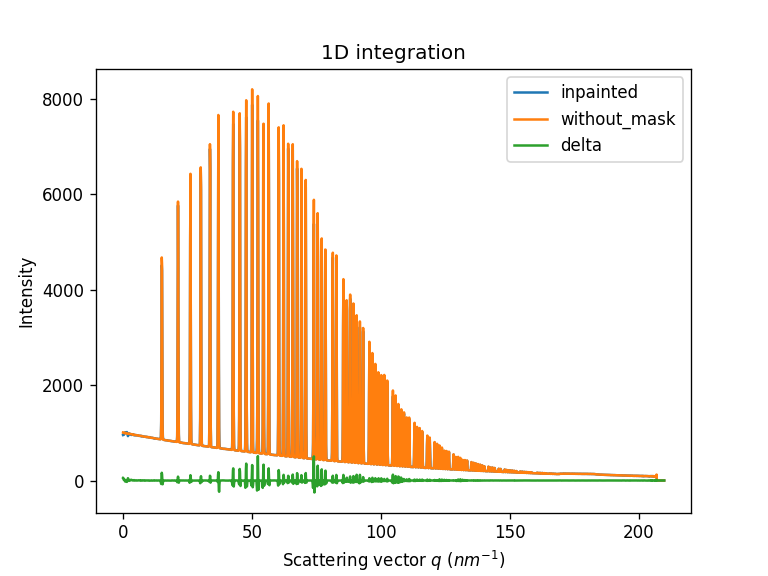

R= 1.2966049578255847


In [8]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

One can see by zooming in that the main effect on inpainting is a broadening of the signal in the inpainted region. This could (partially) be adressed by increasing the number of radial bins used in the inpainting.

## Benchmarking and optimization of the parameters

The parameter set depends on the detector, the experiment geometry and the type of signal on the detector. Finer detail require finer slicing.

In [9]:
#Basic benchmarking of execution time for default options:
%timeit inpainted = ai.inpainting(img, mask=mask)

490 ms ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
for j in ("csr", "csr_nosplit"):
    for k in (512,1024,2048, 4096):
        ai.reset()
        for i in range(10):
            inpainted = ai.inpainting(img, mask=mask, poissonian=True, method=j, npt_rad=k, grow_mask=i)
            wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
            print("method: %s npt_rad=%i grow=%i; R= %s"%(j, k, i,pyFAI.utils.mathutil.rwp(wm,wo)))

method: csr npt_rad=512 grow=0; R= 3.170124270147675
method: csr npt_rad=512 grow=1; R= 2.9085309773095838
method: csr npt_rad=512 grow=2; R= 2.7093841440982853
method: csr npt_rad=512 grow=3; R= 2.6581169860035927
method: csr npt_rad=512 grow=4; R= 2.6209566666383686
method: csr npt_rad=512 grow=5; R= 2.5794065079254884
method: csr npt_rad=512 grow=6; R= 2.5444562914992463
method: csr npt_rad=512 grow=7; R= 2.549743932675981
method: csr npt_rad=512 grow=8; R= 2.540718719264078
method: csr npt_rad=512 grow=9; R= 2.5304376956498174
method: csr npt_rad=1024 grow=0; R= 1.6912521419477502
method: csr npt_rad=1024 grow=1; R= 1.3247887739329023
method: csr npt_rad=1024 grow=2; R= 1.3161812619215125
method: csr npt_rad=1024 grow=3; R= 1.2966318233491858
method: csr npt_rad=1024 grow=4; R= 1.2774988692159988
method: csr npt_rad=1024 grow=5; R= 1.2786549405885803
method: csr npt_rad=1024 grow=6; R= 1.2742461148884427
method: csr npt_rad=1024 grow=7; R= 1.2696721684256065
method: csr npt_rad=102

method: csr npt_rad=4096 grow=9; R= 0.42508187897474914
method: csr_nosplit npt_rad=512 grow=0; R= 3.87778094764105
method: csr_nosplit npt_rad=512 grow=1; R= 2.966570944274723
method: csr_nosplit npt_rad=512 grow=2; R= 2.682447632720386
method: csr_nosplit npt_rad=512 grow=3; R= 2.6198700747539787
method: csr_nosplit npt_rad=512 grow=4; R= 2.582629725313206
method: csr_nosplit npt_rad=512 grow=5; R= 2.6130435142764514
method: csr_nosplit npt_rad=512 grow=6; R= 2.5877939696062358
method: csr_nosplit npt_rad=512 grow=7; R= 2.546132999996073
method: csr_nosplit npt_rad=512 grow=8; R= 2.5274516388891044


method: csr_nosplit npt_rad=512 grow=9; R= 2.528249582388483
method: csr_nosplit npt_rad=1024 grow=0; R= 2.7660427476259897
method: csr_nosplit npt_rad=1024 grow=1; R= 1.4367600906976261
method: csr_nosplit npt_rad=1024 grow=2; R= 1.34645106633035
method: csr_nosplit npt_rad=1024 grow=3; R= 1.2934214897218705
method: csr_nosplit npt_rad=1024 grow=4; R= 1.2692344820866073
method: csr_nosplit npt_rad=1024 grow=5; R= 1.2982623092225032
method: csr_nosplit npt_rad=1024 grow=6; R= 1.1735873046109415
method: csr_nosplit npt_rad=1024 grow=7; R= 1.151382530520178
method: csr_nosplit npt_rad=1024 grow=8; R= 1.1556824453540195
method: csr_nosplit npt_rad=1024 grow=9; R= 1.1699804535574372


method: csr_nosplit npt_rad=2048 grow=0; R= 2.797769874792272
method: csr_nosplit npt_rad=2048 grow=1; R= 1.27042143232188
method: csr_nosplit npt_rad=2048 grow=2; R= 1.1376782721342111
method: csr_nosplit npt_rad=2048 grow=3; R= 1.06383167813538
method: csr_nosplit npt_rad=2048 grow=4; R= 0.9850350638988244
method: csr_nosplit npt_rad=2048 grow=5; R= 0.9252692934916625
method: csr_nosplit npt_rad=2048 grow=6; R= 0.8636066539866318
method: csr_nosplit npt_rad=2048 grow=7; R= 0.8023226637711217
method: csr_nosplit npt_rad=2048 grow=8; R= 0.8072531054334791


method: csr_nosplit npt_rad=2048 grow=9; R= 0.784373672541376
method: csr_nosplit npt_rad=4096 grow=0; R= 2.7067611668860807
method: csr_nosplit npt_rad=4096 grow=1; R= 1.2394279711575453
method: csr_nosplit npt_rad=4096 grow=2; R= 1.2165932157021473
method: csr_nosplit npt_rad=4096 grow=3; R= 1.190030979418953
method: csr_nosplit npt_rad=4096 grow=4; R= 1.1738048509114352
method: csr_nosplit npt_rad=4096 grow=5; R= 1.1537192136120997
method: csr_nosplit npt_rad=4096 grow=6; R= 1.1051660674568167
method: csr_nosplit npt_rad=4096 grow=7; R= 1.070571573638063
method: csr_nosplit npt_rad=4096 grow=8; R= 1.023948688408846
method: csr_nosplit npt_rad=4096 grow=9; R= 1.009366996865416


CPU times: user 5.04 s, sys: 355 ms, total: 5.4 s
Wall time: 981 ms


<IPython.core.display.Javascript object>


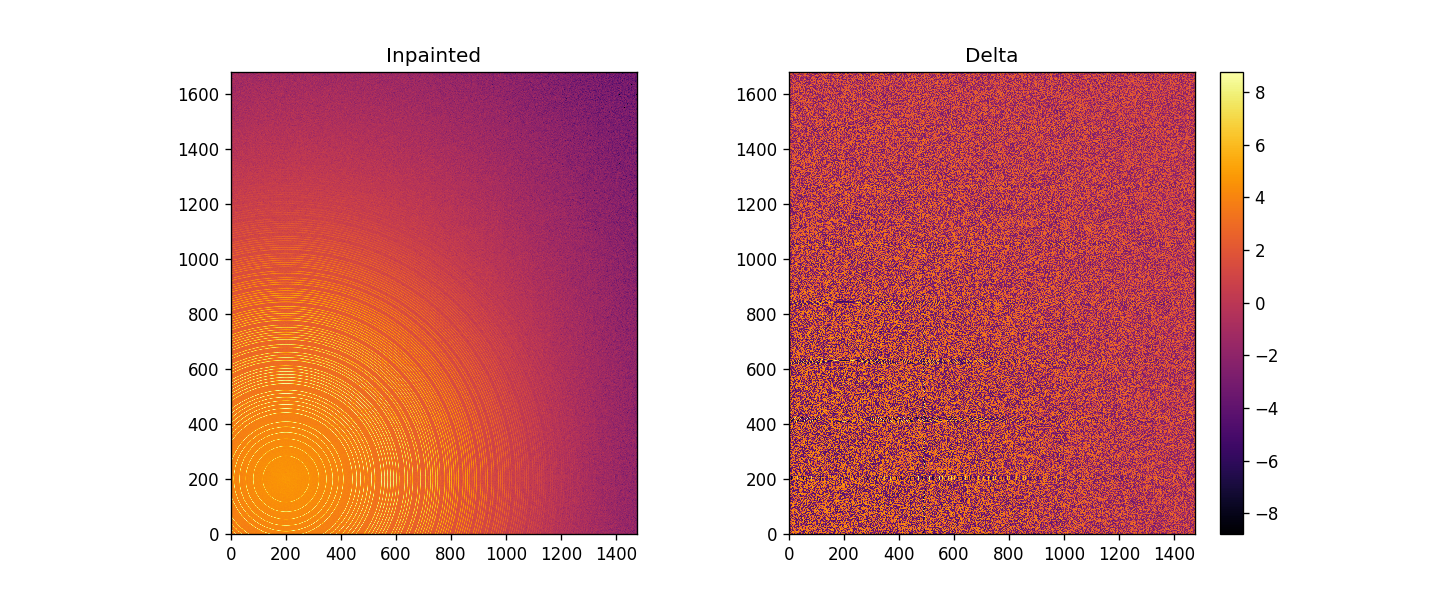

In [11]:
#Inpainting, best solution found:
ai.reset()
%time inpainted = ai.inpainting(img, mask=mask, poissonian=True, method="csr", npt_rad=4096, grow_mask=5)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


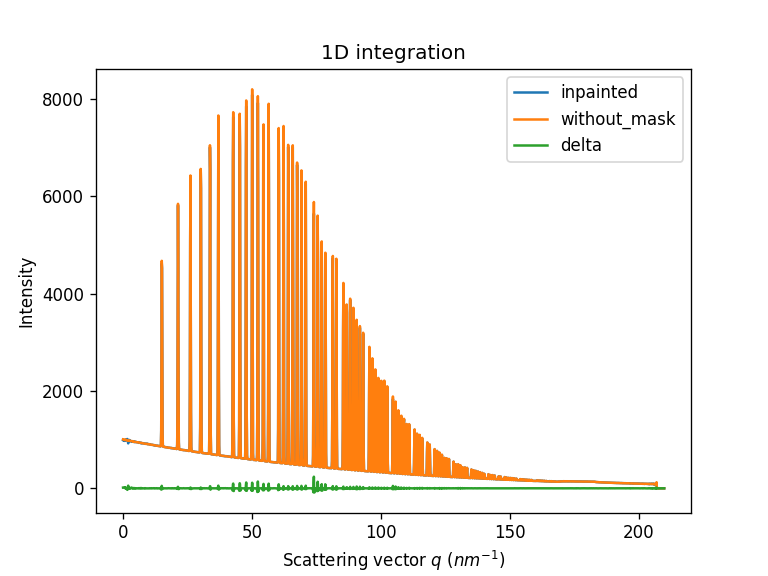

R= 0.4207968636875844


In [12]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

## Conclusion

Inpainting is one of the only solution to fill up the gaps in detector when Fourier analysis is needed. 
This tutorial explains basically how this is possible using the pyFAI library and how to optimize the parameter set for inpainting. The result may greatly vary with detector position and tilt and the kind of signal (amorphous or more spotty).

In [13]:
print("Execution time: %.3fs"%(time.time()-start_time))

Execution time: 63.480s
